# Лабораторная работа 4. Подбор гиперпараметров. Калибровка. Работа с текстовыми данными. Библиотека Vowpal Wabbit.

Результат лабораторной работы − отчет. Мы предпочитаем принимать отчеты в формате ноутбуков IPython (ipynb-файл). Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Помимо ответов на вопросы, в отчете также должен быть код, однако чем меньше кода, тем лучше всем: нам − меньше проверять, вам — проще найти ошибку или дополнить эксперимент. При проверке оценивается четкость ответов на вопросы, аккуратность отчета и кода.

Мы уверены, что выполнение лабораторных работ занимает значительное время, поэтому не рекомендуем оставлять их на последний вечер перед сдачей.

### Оценивание и штрафы
* Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи)
* Максимально допустимая оценка за работу — 15 баллов
* Сдавать задание после указанного срока сдачи нельзя
* «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов и понижают карму (подробнее о плагиате см. на странице курса)
* Если вы нашли решение какого-то из заданий в открытом источнике, необходимо прислать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник)
* Не оцениваются задания с удалёнными формулировкам
* Не оценивается лабораторная работа целиком, если она была выложена в открытый источник

Обратите внимание, что мы не ставим оценку за просто написанный код, корректная работоспособность которого не подтверждена экспериментами.

### Правила сдачи
Выполненную работу следует отправить в систему Anytask. Более подробно о системе можно почитать на странице курса. Название отправляемого файла должно иметь следующий формат: Surname_Name_Group_NN.ipynb, где NN — номер лабораторной работы. Например, Kozlova_Anna_CS_04.ipynb.

## Оценивание качества классификации

Перед тем, как приступить к выполнению заданий, рассмотрим метрики классификации, которые нам пригодятся в дальнейшем.

### Accuracy, Precision, Recall

- Accuracy: $$ Accuracy = \frac{1}{l}\sum_{i=1}^l[y_i = \hat{y}_i]$$ где $y_i$ — истинный ответ на объекте $x_i$, $\hat{y}_i$ — предсказанный. (Мы не рекомендуем переводить *accuracy* как точность, потому что в русскоязычной литературе точностью называют другую метрику)
- Precision (точность): $$Precision = \frac{TP}{TP + FP}$$
- Recall (полнота): $$Recall = \frac{TP}{TP + FN}$$

где обозначения *TP*, *FP*, *FN* и *TN* — элементы матрицы ошибок:

| | y = 1 | y = 0 |
|------|------|
|   a(x) = 1  | TP| FP |
| a(x) = 0| FN | TN |

Обратите внимание, что точность и полнота вычисляются относительно фиксированного класса. В sklearn есть удобная функция [classification_report](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html), позволяющая сразу вычислять эти метрики для всех классов. 

Точность и полнота хороши тем, что могут быть использованы в случае несбалансированных данных, однако сразу же две метрики оптимизировать не удобно.

### Precision-Recall кривая

Зачастую классификатор может возвращать не конкретный класс, а некоторую меру принадлежности заданному классу $b(x)$. Затем значение $b(x)$ сравнивается с фиксированным порогом *t*, и на самом деле классификатор имеет вид $a(x) = [b(x) > t]$. Таким образом, при оценивании качества работы классификатора можно использовать его ответ $b(x)$ и подбирать порог *t* исходя из некоторых условий. Кроме того, выбор порога влияет на качество классификации:
 - чем больше $t$, тем выше точность, но ниже полнота,
 - чем меньше $t$, тем выше полнота, но ниже точность.

Раз мы умеем варьировать порог классификатора, тем самым меняя качество, интересно каким оно будет при всех возможных различных порогах. Для этого строят следующий график: переберем все возможные пороги $t$, откладывая по оси OX полноту получившегося классификатора, а по оси OY — точность. Таким образом можно получить хорошую визуализацию качества алгоритма.

### ROC кривая

Еще один из способ визуализации зависимости метрик качества от порога, подходящей в этом случае, является *ROC*. По осям: 
 - OX: $FPR = \frac{FP}{FP + TN}$
 - OY: $TPR = \frac{TP}{TP + FN}$

Как следствие, можно измерять площади под указанными кривыми — *Precision-Recall AUC* и *AUC-ROC* соответственно.

### LogLoss

В бинарном случае эта метрика записывается как $$logloss = -\dfrac{1}{N}\sum_{i=1}^N (y_i\log{p_i} + (1-y_i)\log{(1 - p_i)})$$

В отличии от *AUC-ROC*, для этой метрики необходимо, чтобы классификатор умел предсказывать вероятность принадлежности к классу, а не "степень принадлежности классу 1" в неопределенной шкале. Приведем пример. Вероятностная шкала может быть нужна, если вы хотите оценить количество денег, которые в среднем принесёт пользователь, кликнув на баннер. Для этого необходимо умножить количество денег, которые вы получаете за клик на баннер, на вероятность клика пользователя, которую предсказывает модель.

## Подбор гиперпараметров. Случайный поиск по сетке

Вы уже знаете, что для подбора гиперпараметров есть способ перебора по сетке. Обычно перебор некоторых значений гиперпараметров ведется по логарифмической шкале, так как это позволяет быстрее определить какого порядка должен быть параметр, и в то же время значительно уменьшить время поиска. Последний нюанс бывает особо критичен, так как для каждого фиксированного набора гиперпараметров происходит новое обучение алгоритма и оценка качества. 

Однако такой подход к нахождению гиперпараметров является не единственным возможным. Рассмотрим более подробно в чем может заключаться недостаток предыдущего подхода. Допустим, вам нужно подобрать 2 гиперпараметра, для каждого из которых есть сетка из 4 возможных значений. То есть всего 16 итераций обучения по сетке. Допустим также, что для оценки качества используется 5-fold CV. В итоге алгоритм будет обучен 80 раз, что уже немало. А если, например, рассмотреть случайный лес, где гиперпараметрами могут являться критерий ветвления, максимальная глубина деревьев, минимальное число объектов в листьях, максимальное число признаков, количество листьев и так далее, может получиться экспоненциально большое число обучений алгоритма, что займёт очень много времени. Для того чтобы как-то ускорить процесс и в то же время найти близкие к оптимальным значения используют **случайный** поиск по сетке. В этом случае для каждого гиперпараметра задается распределение, из которого выбираются его значения. И так как каждый раз значение каждого гиперпараметра выбирается случайно, это позволяет находить оптимум быстрее. 

Сравнение обычного поиска по сетке со случайным можно проиллюстрировать следующим образом:

![](http://blog.kaggle.com/wp-content/uploads/2015/07/scikitlearn8.jpeg)

Более детально о случайном поиске по сетке можно прочесть по следующим ссылкам:
 - теоретический анализ случайного поиска [Random Search for Hyper-Parameter Optimization](http://jmlr.csail.mit.edu/papers/volume13/bergstra12a/bergstra12a.pdf)
 - кратко и с юмором [Smarter Parameter Sweeps (or Why Grid Search Is Plain Stupid)](https://medium.com/rants-on-machine-learning/smarter-parameter-sweeps-or-why-grid-search-is-plain-stupid-c17d97a0e881#.pkwq17od8)
 
В sklearn случайный поиск по сетке реализован в классе [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV).

При выполнении этой части задания будем использовать [набор данных](http://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients) с информацией о клиентах банка и их платежах.

![](https://s2.postimg.org/jm4gryimx/dataset-cover.jpg)

Загрузите данные из файла *credit_card_clients.tsv* и разбейте на обучающее и тестовое множество в отношении 4 к 1.

In [3]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, KFold
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, precision_recall_curve, roc_curve, auc, average_precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from tqdm import tqdm_notebook as tqdm
import time
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

In [107]:
data = pd.read_csv('credit_card_clients.tsv', sep='\t')
data.shape

(30000, 25)

In [108]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [109]:
X, y = data.drop(columns=['ID', 'default payment next month']), data['default payment next month']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**(2 балла) Задание 1.**

Целью данного задания является сравнение описанных выше подходов подбора гиперпараметров на практике. А именно, посмотрим как ведет себя обычный и случайный поиск по сетке при одинаковом числе операций (бюджете). Попробуем найти оптимальные гиперпараметры для SVM с линейным ядром. В данном случае нам будет интересно найти значения у двух гиперпараметров: коэффициент регуляризации *C* и количество итераций *max_iter*. Для обоих гиперпараметров возьмите логарифмическую шкалу (см. функцию [logspace](http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.logspace.html)), для *C* от 0.1 до 100, для *max_iter* от 1000 до 10000. В качестве оптимизируемой метрики качества выберем *AUC-ROC*.

 - Для обычного поиска по сетке ([GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV)) подготовьте 5 сеток гиперпараметров, так чтобы каждый у каждого гиперпараметра перебиралось 2, 3, 4, 5 и 6 значений в соответствующей сетке. Таким образом у вас получится 5 запусков поиска параметров с бюджетом 4, 9, 16, 25, 36. 

 - Для случайного поиска ([RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV)) сделайте 5 запусков поиска гиперпараметров с бюджетом 4, 9, 16, 25, 36. 

 - Для каждого из запусков алгоритма подбора гиперпараметров (одного — обычной и 5 для случайного) вычислите наилучшее достигнутое качество для каждого бюджета. После чего постройте график, где по оси OX будет отложен бюджет, а по оси OY — наилучшее качество.
 
Данная часть лабораторной работы может работать значительное время. Поэтому рекомендуем обратить внимание на параметр *n_jobs* поиска по сетке (есть у обоих классов).

In [110]:
np.logspace(-1, 2, num=2)

array([  0.1, 100. ])

In [111]:
params1 = {'C' : np.logspace(-1, 2, num=2), 'max_iter' : np.logspace(3, 4, num=2)}
params2 = {'C' : np.logspace(-1, 2, num=3), 'max_iter' : np.logspace(3, 4, num=3)}
params3 = {'C' : np.logspace(-1, 2, num=4), 'max_iter' : np.logspace(3, 4, num=4)}
params4 = {'C' : np.logspace(-1, 2, num=5), 'max_iter' : np.logspace(3, 4, num=5)}
params5 = {'C' : np.logspace(-1, 2, num=6), 'max_iter' : np.logspace(3, 4, num=6)}
params = [params1, params2, params3, params4, params5]

svc = SVC(kernel='linear')
kf = KFold(5)
best_GridSearchCV_results = []
for param in tqdm(params):
    clf = GridSearchCV(svc, param, n_jobs=4, cv=kf, scoring='roc_auc')    
    clf.fit(np.array(X), np.array(y))
    print(clf.best_score_, clf.best_params_)
    best_GridSearchCV_results.append(clf.best_score_)

0.5702747801395761 {'C': 100.0, 'max_iter': 10000.0}
0.5861775297220212 {'C': 3.1622776601683795, 'max_iter': 3162.2776601683795}
0.5854385002274093 {'C': 1.0, 'max_iter': 4641.588833612777}
0.6086883658229646 {'C': 17.78279410038923, 'max_iter': 3162.2776601683795}
0.5930356155397615 {'C': 25.118864315095795, 'max_iter': 1584.893192461114}



In [112]:
best_GridSearchCV_results

[0.5702747801395761,
 0.5861775297220212,
 0.5854385002274093,
 0.6086883658229646,
 0.5930356155397615]

In [113]:
from scipy.stats import uniform, randint as sp_randint

param_dict = {"C": uniform(0.1, 100.),
              "max_iter": sp_randint(1000,  10000)}
best_RandomizedSearchCV_results = []
for i in tqdm(range(2, 7)):
    clf = RandomizedSearchCV(svc, param_dict, i**2, n_jobs=4, cv=kf, scoring='roc_auc')    
    clf.fit(np.array(X), np.array(y))
    print(clf.best_score_, clf.best_params_)
    best_RandomizedSearchCV_results.append(clf.best_score_)

0.5950031138795654 {'C': 65.91752905746148, 'max_iter': 7509}
0.5790153109581718 {'C': 62.1804507988062, 'max_iter': 2563}
0.6107618951665166 {'C': 73.96301399039749, 'max_iter': 6845}
0.5958804350960614 {'C': 5.8894409915785975, 'max_iter': 2271}
0.6111310943472689 {'C': 60.62788783549924, 'max_iter': 1944}



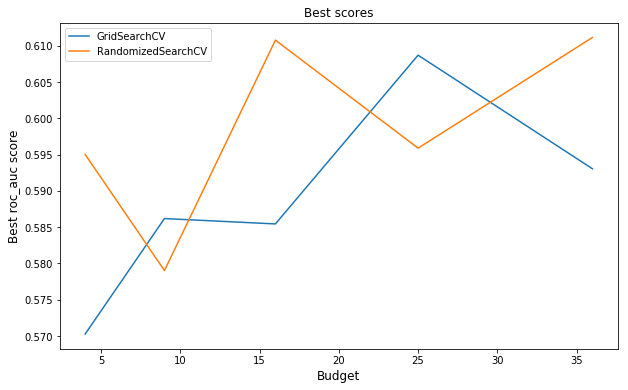

In [115]:
plt.figure(figsize=(10, 6))
plt.plot([4, 9, 16, 25, 36], best_GridSearchCV_results, label="GridSearchCV")
plt.plot([4, 9, 16, 25, 36], best_RandomizedSearchCV_results, label="RandomizedSearchCV")
plt.title("Best scores")
plt.xlabel("Budget", fontsize=12)
plt.ylabel("Best roc_auc score", fontsize=12)
plt.legend()

**(1 балл) Задание 2.**

Сравните полученные графики для разных способов подбора гиперпараметров:
 * Посмотрите на наилучшие гиперпараметры, которые у вас получились. Можно ли сказать, что какой-то из гиперпараметров больше влияет на результат?

<font size=4, color=blue>Кажется, что по данным только о результатах на наилучших гиперпараметрах в данном случае сложно судить об их "информативности". Например, можем посмотреть, как изменился скор при одинаковых max_iter и разных C:
$$0.5861775297220212, \{'C': 3.1622776601683795, 'max\_iter': 3162.2776601683795\}$$
$$0.6086883658229646, \{'C': 17.78279410038923, 'max\_iter': 3162.2776601683795\}$$
Видим, что скор изменился на 0.02. Однако, теперь можем посмотреть на примерно одинаковые значения C и разные значения max_iter:
$$0.5950031138795654, \{'C': 65.91752905746148, 'max\_iter': 7509\}$$
$$0.5790153109581718, \{'C': 62.1804507988062, 'max\_iter': 2563\}$$
$$0.6111310943472689, \{'C': 60.62788783549924, 'max\_iter': 1944\}$$
Видим и в этом случае довольно серьезный разброс: 0.04. С одной сторону, можно подумать, что 0.04 в два раза больше, чем 0.02, однако, как мне кажется, данных всё равно слишком мало, чтобы делать далеко идущие выводы о том, какой параметр важнее.</font>

* Можно ли сделать вывод, что случайный поиск проигрывает или же наоборот?

<font size=4, color=blue>Исходя из полученных графиков, нельзя с уверенностью говорить о проигрыше или выигрыше в случае использования случайного поиска. При совсем маленьком бюджете случайный поиск может выигрывать, поскольку в случае использования фиксированной сетки точки могут быть слишком разреженны. При среднем бюджете поиск по сетке может начать выигрывать, поскольку сетка будет уже не такой разреженной, а точки в случае случайного поиска могут с большой вероятностью оказаться слишком сконцентрированны в одной области. При большом же бюджете скорее всего разницы в методах заметной не будет.

* Зависит ли ответ на предыдущий вопрос от размера бюджета и удачной инициализации?

<font size=4, color=blue> Часть ответа на вопрос была дана в предыдущем пункте. Удачная инициализация так же играет роль (так, например, можно и не получить выигрыша в случае случайного поиска при маленьком бюджете, если точки окажутся сконцентрированы не в области минимума)

## Калибровка классификатора

Рассмотрим в задачу, где целевой метрикой является *logloss*. Как было сказано выше, в этом случае необходимо, чтобы классификатор умел предсказывать вероятность принадлежности к классу. К сожалению, на практике часто получается так, что либо классификатор не обладает желаемым свойством (например, SVM без специальных настроек), либо метод *predict_proba* возвращает некорректную вероятность (например, случайный лес возвращает среднее арифметическое вероятностей от каждого дерева, которое не обязано являться корректной вероятностью, подробнее [здесь](http://people.dsv.su.se/~henke/papers/bostrom08b.pdf)).

В этом случае возможны несколько подходов: 
 - Заменить классификатор на тот, который умеет предсказывать вероятности.
 - Воспользоваться калибровкой ответов.
 
В общем случае первый подход не самый удачный выбор, так как накладывает ограничения на модели, которые можно использовать. Поэтому рассмотрим второй более подробно. По умолчанию SVM может вычислять отступ от заданного объекта до разделяющей гиперплоскости, а не возвращать вероятности. После чего можно обучить преобразование, которое искажает возвращаемое значение в вероятность  — это и называется **калибровкой**. Есть несколько известных методов калибровки:
 - Калибровка Платта.
 - Изотоническая регрессия.

Обратите внимание, что преобразование необходимо обучать на отложенной выборке (то есть классификатор и калибровка должны обучаться на разных подмножествах данных), иначе можно переобучиться. Калибровку можно применять к любым классификаторам (где это разумно и необходимо), особенно к тем, которые не оптимизируют logloss явно.

Для калибровки классификатора в sklearn возможны два подхода:
 - взять уже обученный классификатор и откалибровать его на отложенной выборке
 - откалибровать по кросс-валидации: калибровочному классификатору передается вся обучающая выборка, которая внутри разбивается на обучающую и калибровочную, после чего происходит усреднение вероятностей по фолдам.
 
Подробнее об этом можно прочитать в [документации](http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html#sklearn.calibration.CalibratedClassifierCV). Также [здесь](https://jmetzen.github.io/2015-04-14/calibration.html) можно узнать подробности о калибровке в sklearn от автора.

Замечание: выше написано, что SVM по умолчанию не возвращает вероятности. Если же заглянуть в документацию [SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html), то можно найти параметр *probability*. Если установить его равным *True*, то у такого классификатора можно вызвать метод *predict_proba* и получить оценки вероятностей. В библиотеке реализована калибровка Платта и с классификатором проделывается примерно тоже самое, что было описано выше. Использование этого параметра замедляет процесс обучения, зато позволяет сразу же использовать данный классификатор для оценивания вероятностей. Обратите внимание, что у класса [LinearSVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) такой опции нет.

**(2 балла) Задание 3.**
 
Рассмотрим SVM из предыдущего пункта. Используйте оба описанных выше подхода (калибровку Платта и изотоническую регрессию) для калибровки классификатора. Для каждого из подходов постройте график, на котором будут изображены [калибровочные кривые](http://scikit-learn.org/stable/modules/generated/sklearn.calibration.calibration_curve.html): идеальная, исходного классификатора, а также для каждого из методов на обучающей выборке. Калибровочная кривая строится путем упорядочения всех объектов по предсказанному значению, которые разбиваются на бины. По оси OX откладывается среднее предсказанное значение вероятности по бину, а по OY — доля положительных примеров. В случае идеальных вероятностей это будет прямая.
 
В данном задании необходимо воспользоваться методом *decision_function*, возвращающим значение отступа на объекте. После этого отмасштабируйте полученные отступы в интервал [0, 1], применив сигмоиду или линейное преобразование.

In [145]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

svc = SVC(kernel='linear', C=17.78279410038923, max_iter=3162.2776601683795)
X_train_svc, X_calibration, y_train_svc, y_calibration = train_test_split(X_train, y_train)
svc.fit(X_train_svc, y_train_svc)
isotonic = CalibratedClassifierCV(svc, cv='prefit', method='isotonic')
platt = CalibratedClassifierCV(svc, cv='prefit', method='sigmoid')
isotonic.fit(X_calibration, y_calibration)
platt.fit(X_calibration, y_calibration)

CalibratedClassifierCV(base_estimator=SVC(C=17.78279410038923, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=3162.2776601683795, probability=False,
  random_state=None, shrinking=True, tol=0.001, verbose=False),
            cv='prefit', method='sigmoid')

In [146]:
curve_svc = svc.decision_function(X_test)
curve_svc = (curve_svc - curve_svc.min()) / (curve_svc.max() - curve_svc.min())

curve_isotonic = isotonic.predict_proba(X_test)[:, 1]

curve_platt = platt.predict_proba(X_test)[:, 1]

fraction_of_positives_svc, mean_predicted_value_svc =  calibration_curve(y_test, curve_svc, n_bins=20)
fraction_of_positives_isotonic, mean_predicted_value_isotonic =  calibration_curve(y_test, curve_isotonic, n_bins=20)
fraction_of_positives_platt, mean_predicted_value_platt =  calibration_curve(y_test, curve_platt, n_bins=20)

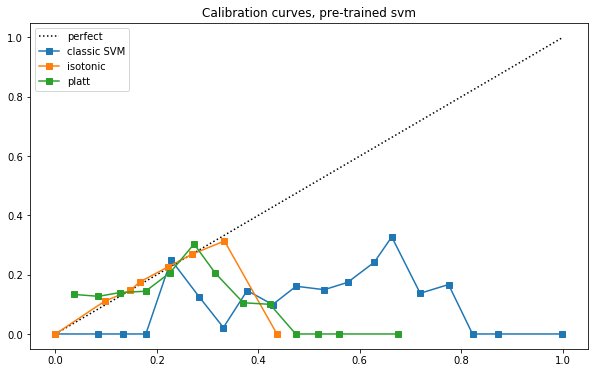

In [147]:
plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], "k:", label="perfect")
plt.plot(mean_predicted_value_svc, fraction_of_positives_svc, "s-",
                 label="classic SVM")
plt.plot(mean_predicted_value_isotonic, fraction_of_positives_isotonic, "s-",
                 label="isotonic")
plt.plot(mean_predicted_value_platt, fraction_of_positives_platt, "s-",
                 label="platt")
plt.title("Calibration curves, pre-trained svm")
plt.legend()

In [128]:
svc2 = SVC(kernel='linear', C=17.78279410038923, max_iter=3162.2776601683795)
svc2.fit(X_train, y_train)
isotonic2 = CalibratedClassifierCV(svc, cv=5, method='isotonic')
platt2 = CalibratedClassifierCV(svc, cv=5, method='sigmoid')
isotonic2.fit(X_train, y_train)
platt2.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=SVC(C=17.78279410038923, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=3162.2776601683795, probability=False,
  random_state=None, shrinking=True, tol=0.001, verbose=False),
            cv=5, method='sigmoid')

In [129]:
curve_svc2 = svc2.decision_function(X_test)
curve_svc2 = (curve_svc2 - curve_svc2.min()) / (curve_svc2.max() - curve_svc2.min())

curve_isotonic2 = isotonic2.predict_proba(X_test)[:, 1]

curve_platt2 = platt2.predict_proba(X_test)[:, 1]

fraction_of_positives_svc2, mean_predicted_value_svc2 =  calibration_curve(y_test, curve_svc2, n_bins=20)
fraction_of_positives_isotonic2, mean_predicted_value_isotonic2 =  calibration_curve(y_test, curve_isotonic2, n_bins=20)
fraction_of_positives_platt2, mean_predicted_value_platt2 =  calibration_curve(y_test, curve_platt2, n_bins=20)

Text(0.5, 1.0, 'Calibration curves, cv')

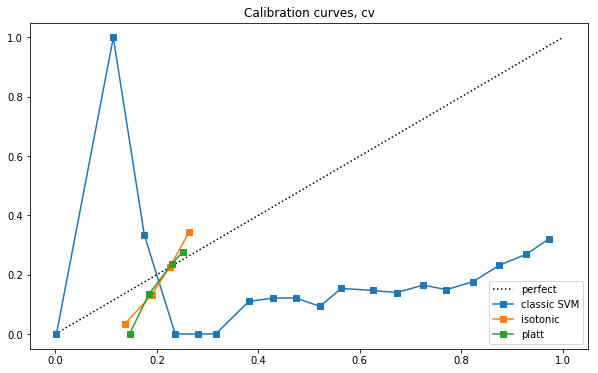

In [130]:
plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], "k:", label="perfect")
plt.plot(mean_predicted_value_svc2, fraction_of_positives_svc2, "s-",
                 label="classic SVM")
plt.plot(mean_predicted_value_isotonic2, fraction_of_positives_isotonic2, "s-",
                 label="isotonic")
plt.plot(mean_predicted_value_platt2, fraction_of_positives_platt2, "s-",
                 label="platt")
plt.legend()
plt.title("Calibration curves, cv")

**(1 балл) Задание 4.**
 - Посчитайте *logloss* на тестовой выборке для исходного и классификатора после калибровки.

In [134]:
from sklearn.metrics import log_loss

print("In case of pretrained svm:")
print("Initial classifier logloss:", log_loss(y_test, curve_svc))
print("Isotonic logloss:", log_loss(y_test, curve_isotonic))
print("Platt logloss:", log_loss(y_test, curve_platt))

In case of pretrained svm:
Initial classifier logloss: 0.6996771339602137
Isotonic logloss: 0.5254278088398907
Platt logloss: 0.5183633889969675


In [135]:
print("In case of crossval:")
print("Initial classifier logloss:", log_loss(y_test, curve_svc2))
print("Isotonic logloss:", log_loss(y_test, curve_isotonic2))
print("Platt logloss:", log_loss(y_test, curve_platt2))

In case of crossval:
Initial classifier logloss: 1.6358106289902916
Isotonic logloss: 0.5153271739385168
Platt logloss: 0.5181333939056774


- Дает ли калибровка прирост качества относительно метрики logloss?

<font size=4, color=blue> Как очевидно следует из результатов, калибровка дает прирост качества относительно метрики logloss.

- Какой из способов калибровки в данном случае работает лучше?

<font size=4, color=blue> В случае испозования метода предобученной модели и калибровки на отложенной выборке, лучше сработала калибровка Платта, а в случае калибровки по кросс-валидации, чуть лучше оказалась изотоническая регрессия.

- Какой из подходов (калибровка на отложенной выборке или по кросс-валидации) дает более хороший результат?

<font size=4, color=blue> Чуть лучше результаты в случае использования калибровки по кросс-валидации.

- Почему калибровка практически не должна повлиять на *AUC-ROC*? 

<font size=4, color=blue> Калибровка практически не должна повлиять на AUC-ROC, потому что для построения ROC-кривой в случае SVM необходимо знать только расстояния до разделяющей поверхности, которые не сильно изменятся в случае калибровки.

## Работа с текстовыми данными

В остальной части задания мы будем работать с подмножеством датасета IMDB Movies Reviews из соревнования [Bag of Words Meets Bags of Popcorn](https://www.kaggle.com/c/word2vec-nlp-tutorial/data). 
![](http://i.imgur.com/QZgxFic.png)

Задача состоит в следующем: по отзыву на фильм необходимо понять является ли он положительным или отрицательным. Это один из примеров задачи анализа тональности текста ([sentiment analysis](https://en.wikipedia.org/wiki/Sentiment_analysis)). Пример отзыва из выборки:
    
    This can be one of the most enjoyable movies ever if you don't take it seriously. It is a bit dated and the effects are lame, but it is so enjoyable. There are giant crabs that attack a girl. oh, and the crabs sing Japanese. It is amazingly bad. And the ending, which has been telegraphed throughout the entire film is hideously awesome. Predictable, but seeing the final fight will leave you rolling in your seat. Don't even give this film a chance and you will love it. Susan George is fun to watch and yes, she does appear naked. Her daughter isn't quite worth putting up with, but she does get attacked by giant crabs. They are the size of large cats. This is a 2, but I love it. As a movie, my God, but for entertainment, I give it a 7. Did I mention there are giant crabs?

Загрузите датасет из файла *feedback_data.tsv*.

In [4]:
cinemas = pd.read_csv('feedback_data.tsv', sep='\t')
X, y = np.array(cinemas['review']), np.array(cinemas['sentiment'])

In [5]:
cinemas.head()

,id,sentiment,review
0,6678_2,0,"This is a copy of the 1948 Doris Day classic, ..."
1,11589_3,0,Bottom-of-the-Freddy barrel. This is the worst...
2,6760_2,0,Renown writer Mark Redfield (as Edgar Allen Po...
3,1150_4,0,Although there are some snippets in this 4-par...
4,11913_4,0,"A good idea, badly implemented. While that cou..."


Для оценивания качества в данной задаче мы будем использовать отложенную выборку. Разделите все данные на две части: 16000 объектов будут в обучающей выборке и 4000 объектов — в тестовой.

При разбиении выборки на две части, необходимо будет учесть следующие особенности разбиения:
 - разбиение должно быть воспроизводимо;
 - соотношение классов в каждой из частей должно сохраняться (например, при использовании функции *train_test_split* указать *stratify*).

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=4000, 
                                                    train_size=16000, random_state=40, 
                                                    stratify=y)

Одна из сложностей данной задачи — текстовое представление данных, так как не существует какого-то универсального способа извлечения признаков из текстов. По ходу работы мы получим несколько наборов признаков, которые будем сравнивать между собой.

Для начала попробуем самый простой подход, а именно [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model) кодирование данных. С помощью него каждый текст будет представлен в виде вектора, размер которого равен размеру словаря, а на каждой позиции стоит число, сколько раз соответствующее слово встретилось в этом тексте. Для данного подхода хорошей практикой является фильтрация стоп-слов.

Такое представление можно получить используя класс [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) из библиотеки sklearn. Одно из удобств данного метода состоит в том, что возвращаемый результат является [sparse](http://docs.scipy.org/doc/scipy-0.15.1/reference/sparse.html)-матрицей, так как при таком преобразовании получается достаточно много нулей. Более подробно про такие матрицы было рассказано на [семинаре](https://nbviewer.jupyter.org/urls/dl.dropbox.com/s/xswzs2g414wggh9/seminar_8.ipynb), также про это можно прочитать, например, [здесь](http://www.scipy-lectures.org/advanced/scipy_sparse/index.html).

Примените *bag-of-words* кодирование данных. Мы рекомендуем здесь и в дальнейшем обучать преобразование на обучающей выборке, после чего применять его к тестовой. Какой размерности стали данные?

In [7]:
vectorizer = CountVectorizer(stop_words='english')
vectorizer.fit(X_train)
X_train_new = vectorizer.transform(X_train)
X_test_new = vectorizer.transform(X_test)

In [8]:
X_train_new.shape

(16000, 62139)

In [9]:
X_train_new

<16000x62139 sparse matrix of type '<class 'numpy.int64'>'
	with 1431779 stored elements in Compressed Sparse Row format>

In [10]:
np.sum(y), len(y)

(7500, 20000)

<font size=4, color=blue> Тепень у нас есть 62097 признаков для каждого объекта.

**(0.5 балла) Задание 5.**

Какие недостатки для данной задачи вы видите у метрики *Accuracy*?

<font size=4, color=blue> Метрика Accuracy не учитывает дисбаланс классов. В нашем случае, отношение числа положительных отзывов к числу отрицательных: 3/5, а значит метрика Accuracy будет занижать важность ошибок на одном из классов.

Обучите логистическую регрессию и случайный лес с 500 деревьев на *bag-of-words* представлении выборки и измерьте качество на тестовых данных с помощью трех описанных выше метрик: *Accuracy*, *Precision*, *Recall*. Кроме того, сравните **время** обучения алгоритмов.

In [15]:
lr_model = LogisticRegression(n_jobs=4)
forest_model = RandomForestClassifier(n_estimators=500, n_jobs=4)

In [16]:
t0=time.time()
lr_model.fit(X_train_new, y_train)
print("LogReg training time:", round(time.time()-t0, 3), "s")

LogReg training time: 2.096 s


In [17]:
t0=time.time()
forest_model.fit(X_train_new, y_train)
print("Random forest training time:", round(time.time()-t0, 3), "s")

Random forest training time: 71.694 s


<font size=4, color=blue> Random Forest обучался гораздо дольше логистической регрессии.

In [18]:
y_pred_lr = lr_model.predict(X_test_new)
y_pred_forest = forest_model.predict(X_test_new)

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
print("Logistic regression accuracy:", accuracy_score(y_test, y_pred_lr))
print("Logistic regression precision:", precision_score(y_test, y_pred_lr))
print("Logistic regression recall:", recall_score(y_test, y_pred_lr))
print("\nRandom forest accuracy:", accuracy_score(y_test, y_pred_forest))
print("Random forest precision:", precision_score(y_test, y_pred_forest))
print("Random forest recall:", recall_score(y_test, y_pred_forest))

Logistic regression accuracy: 0.87575
Logistic regression precision: 0.8442004118050789
Logistic regression recall: 0.82

Random forest accuracy: 0.8365
Random forest precision: 0.9307535641547862
Random forest recall: 0.6093333333333333


In [20]:
target_names = ['class 0', 'class 1']
print("Logistic regression results")
print(classification_report(y_test, y_pred_lr, target_names=target_names))
print("\n\n\nRandom forest results")
print(classification_report(y_test, y_pred_forest, target_names=target_names))
print("\n\nP.S.: class 0 = negative, class 1 = positive")

Logistic regression results
              precision    recall  f1-score   support

     class 0       0.89      0.91      0.90      2500
     class 1       0.84      0.82      0.83      1500

   micro avg       0.88      0.88      0.88      4000
   macro avg       0.87      0.86      0.87      4000
weighted avg       0.88      0.88      0.88      4000




Random forest results
              precision    recall  f1-score   support

     class 0       0.81      0.97      0.88      2500
     class 1       0.93      0.61      0.74      1500

   micro avg       0.84      0.84      0.84      4000
   macro avg       0.87      0.79      0.81      4000
weighted avg       0.85      0.84      0.83      4000



P.S.: class 0 = negative, class 1 = positive


Есть ли существенная разница в качестве предсказаний данных алгоритмов? Какой из методов кажется менее применимым в данной задаче и почему?

<font size=4, color=blue> Из результатов видно, что у Random Forest лучше показатель precision на положительных отзывах, однако гораздо хуже, чем у логистической регрессии, показатель recall (и наоборот для отрицательных отзывов). У Random Forest гораздо выше число объектов, ошибочно отнесенных к класссу негативных отзывов (это можно заметить по разнице между precision и recall для класса положительных отзывов у Random Forest). Таким образом, скорее всего Random Forest плохо справляется с дисбалансом классов. Однако, всё же precision на положительном классе достаточно высокий. Random Forest достаточно логично можно интерпертировать в нашей задаче: например, если часто встречается слово "bad", то скорее всего отзыв плохой (или если встречается некоторый ансамль негативных слов). С интерпретацией лог.регрессии в данном случае сложнее, но некоторые ее результаты получше. К тому же, её результаты более "однородны" на обоих классах. Поэтому, однозначный вывод сделать нельзя, но скорее всего логистическая регрессия более применима в данной задаче.

Посмотрев на указанные метрики, можно понять, что классификаторы неплохо справляются с нулевым классом и похуже — с первым. Скорее всего, это является следствием того, что положительных отзывов почти вдвое меньше чем отрицательных. В дальнейшем нас будет интересовать как классификатор справляется именно с положительными отзывами (то есть с первым классом).

**(1.5 балла) Задание 6.**

Постройте *Precision-Recall* и *ROC* кривые обученных выше классификаторов (каждый тип кривой на отдельном графике), а также вычислите площадь под ними. Для этого удобно воспользоваться функциями [precision_recall_curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html), [roc_curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) и [auc](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html#sklearn.metrics.auc). Не забудьте, что в данном случае необходимо использовать метод *predict_proba* для получения оценки принадлежности к первому классу.

In [21]:
y_prob_lr = lr_model.predict_proba(X_test_new)
y_prob_forest = forest_model.predict_proba(X_test_new)

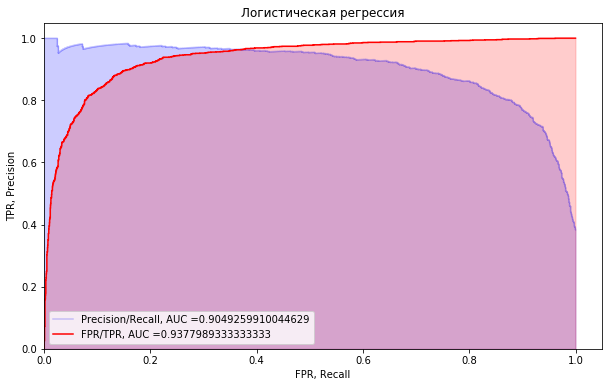

In [22]:
from sklearn.utils.fixes import signature

precision, recall, _ = precision_recall_curve(y_test, y_prob_lr.T[1])
fpr, tpr, _ = roc_curve(y_test, y_prob_lr.T[1], pos_label=1)
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

plt.figure(figsize=(10, 6))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post', label="Precision/Recall, AUC =" + str(auc(recall, precision)))
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.title("Логистическая регрессия")

plt.step(fpr, tpr, color='r', label="FPR/TPR, AUC =" + str(auc(fpr, tpr)))
plt.fill_between(fpr, tpr, alpha=0.2, color='r', **step_kwargs)

plt.xlabel('FPR, Recall')
plt.ylabel('TPR, Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.05])
plt.legend()

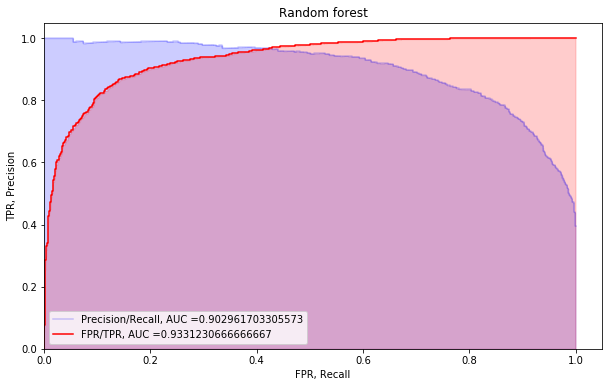

In [23]:
from sklearn.utils.fixes import signature

precision, recall, _ = precision_recall_curve(y_test, y_prob_forest.T[1])
fpr, tpr, _ = roc_curve(y_test, y_prob_forest.T[1], pos_label=1)
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

plt.figure(figsize=(10, 6))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post', label="Precision/Recall, AUC =" + str(auc(recall, precision)))
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.title("Random forest")

plt.step(fpr, tpr, color='r', label="FPR/TPR, AUC =" + str(auc(fpr, tpr)))
plt.fill_between(fpr, tpr, alpha=0.2, color='r', **step_kwargs)

plt.xlabel('FPR, Recall')
plt.ylabel('TPR, Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.05])
plt.legend()

Если мы хотим, чтобы классификатор находил, например, не менее 80% положительных отзывов, то необходимо потребовать, чтобы полнота была не менее 0.8. 

**(1 балл) Задание 7.**

Найдите наибольшую точность, которую будет иметь каждый классификатор при полноте не менее 0.8.

In [24]:
precision, recall, _ = precision_recall_curve(y_test, y_prob_lr.T[1])
res = 0
for i in range(len(recall)):
    if recall[i] >= 0.8 and precision[i] > res:
        res = precision[i]
print("LogReg precision:", res)

LogReg precision: 0.8626887131560029


In [25]:
precision, recall, _ = precision_recall_curve(y_test, y_prob_forest.T[1])
res = 0
for i in range(len(recall)):
    if recall[i] >= 0.8 and precision[i] > res:
        res = precision[i]
print("RandomForest precision:", res)

RandomForest precision: 0.8350658350658351


В дальнейшем для экспериментов будем использовать логистическую регрессию. Можно заметить, что по некоторым причинам мы не находили оптимальные параметры для алгоритмов, а работали с параметрами по умолчанию. Чтобы исправить этот недостаток, в оставшейся части работы используйте понравившийся вам метод поиска гиперпараметров (из описанных выше) для нахождения наилучшего значения параметра *C* у логистической регрессии.

А теперь вернемся к исходной задаче. На данном этапе решения можно прийти к выводу, что предложенное кодирование текста может быть не самым удачным из-за большой матрицы объект-признак. Это ведет к ситуации, что не всякий алгоритм может быть применен в данной задаче по причине слишком большого признакового пространства, а кроме того, даже быстрые алгоритмы при наличии кросс-валидации могут начать работать медленно. Также в данных может быть шум, так как в качестве словаря были взяты все слова, даже те, которые встречались в одном-двух отзывах (например, опечатки). Поэтому кажется что неплохо было бы сократить размерность данных и по возможности избавиться от шума. 

## Отбор признаков и уменьшение размерности

### По частоте
Попробуем сформировать выборку, в которой будут находиться только самые "важные" признаки, то есть в данном случае слова. Например, это можно сделать оставив топ слов по частоте (не считая стоп-слов вроде "a", "the", "it", ...). Кажется, что вхождение наиболее частых слов в отзыве, например, *good*, *bad* и т.д. являются вполне неплохими показателями.

### С помощью машинного обучения
Другой подход — воспользоваться имеющимися методами машинного обучения, а именно обученным на всех признаках случайным лесом. С помощью сдучайного леса есть возможность оценивать важность признаков. То есть можно выбрать топ слов, важных как признаки для задачи классификации. 

### Hashing trick
Какие еще могут быть способы работы с такого рода данными? По факту слова в текстах — это некоторое очень разреженное представление (как мы убедились выше). Подходом, отличным от двух вышеперечисленных, является [хэширование](https://en.wikipedia.org/wiki/Feature_hashing) или hashing trick: каждому слову сопоставляется некоторый хэш, после чего делается, например, bag-of-words. Плюсом этого способа является возможность обрабатывать не встречавшиеся ранее слова. Этот подход реализован в классе [HashingVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html). Кроме того, если выставить параметр *non_negative=True*, то можно интерпретировать полученные значения как некоторые "частоты".

Заметьте, что два последних подхода можно применять не обязательно к текстовым данным.

**(2 балла) Задание 8.**

Сформируйте три новые выборки, где каждый объект будет иметь 15000 признаков, следующим образом:
 - топ самых частотных слов
 - топ наиболее "важных" слов с помощью случайного леса
 - с помощью хэширования
 
Для последних двух выборок не забывайте фильтровать стоп-слова, для этого можно использовать параметр stop_words='english' у классов CountVectorizer, HashingVectorizer.

На четырех выборках (*bag-of-words* и трех новых) постройте *roc*-кривые, вычислив площадь под ними.

In [26]:
tdata = vectorizer.fit_transform(X_train)
sum_words = tdata.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)[:15000]

In [28]:
count_vectorizer = CountVectorizer(stop_words='english', max_features=15000)

X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

In [29]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(forest_model, max_features=15000, threshold=-np.inf, prefit=True)
X_train_forest = sfm.transform(X_train_new)
X_test_forest = sfm.transform(X_test_new)

In [30]:
indexes = [i for i, x in enumerate(sfm.get_support()) if x == True]
forest_keys = np.array(vectorizer.get_feature_names())[indexes]

In [31]:
from sklearn.feature_extraction.text import HashingVectorizer

hash_vectorizer = HashingVectorizer(non_negative=True, stop_words='english', n_features=15000)
X_train_hash = hash_vectorizer.fit_transform(X_train)
X_test_hash = hash_vectorizer.transform(X_test)

In [32]:
from sklearn.linear_model import LogisticRegressionCV
lr_bag = LogisticRegressionCV(n_jobs=4)
lr_forest = LogisticRegressionCV(n_jobs=4)
lr_count = LogisticRegressionCV(n_jobs=4)
lr_hash = LogisticRegressionCV(n_jobs=4)

In [ ]:
param_dict = {"C": uniform(0.1, 100.)}
clf_bag = RandomizedSearchCV(lr_bag, param_dict, 8, n_jobs=4, cv=kf, scoring='roc_auc')    
clf_bag.fit(np.array(X_train_new.todense()), np.array(y_train))
clf_forest = RandomizedSearchCV(lr_forest, param_dict, 8, n_jobs=4, cv=kf, scoring='roc_auc')    
clf_forest.fit(np.array(X_train_forest), np.array(y_train))
clf_count = RandomizedSearchCV(lr_count, param_dict, 8, n_jobs=4, cv=kf, scoring='roc_auc')    
clf_count.fit(np.array(X_train_count), np.array(y_train))
clf_hash = RandomizedSearchCV(lr_hash, param_dict, 8, n_jobs=4, cv=kf, scoring='roc_auc')    
clf_hash.fit(np.array(X_train_hash), np.array(y_train))

In [33]:
lr_bag.fit(X_train_new, y_train)
lr_forest.fit(X_train_forest, y_train)
lr_count.fit(X_train_count, y_train)
lr_hash.fit(X_train_hash, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=4, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [34]:
y_prob_bag = lr_bag.predict_proba(X_test_new)
y_prob_forest = lr_forest.predict_proba(X_test_forest)
y_prob_count = lr_count.predict_proba(X_test_count)
y_prob_hash = lr_hash.predict_proba(X_test_hash)

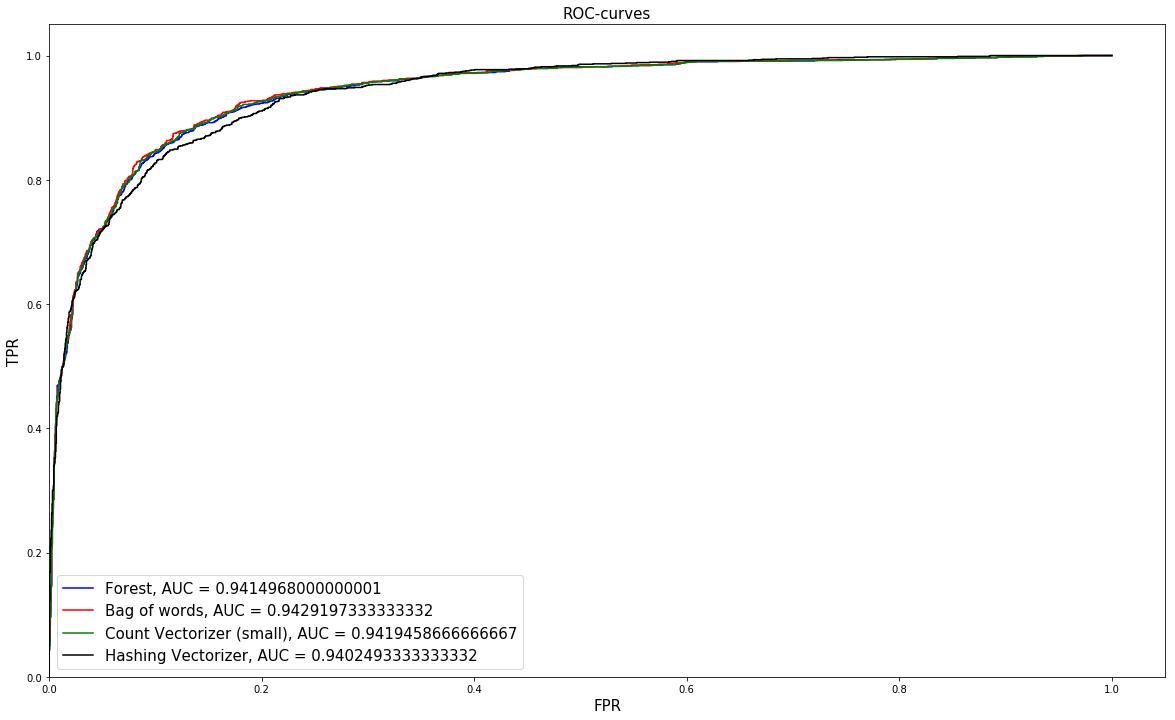

In [42]:
fpr, tpr, _ = roc_curve(y_test, y_prob_forest.T[1], pos_label=1)
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

plt.figure(figsize=(20, 12))
plt.step(fpr, tpr, label="Forest, AUC = " + str(auc(fpr, tpr)), color='b')
#plt.fill_between(fpr, tpr, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('FPR', fontsize=15)
plt.ylabel('TPR', fontsize=15)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.05])

fpr, tpr, _ = roc_curve(y_test, y_prob_bag.T[1], pos_label=1)
plt.step(fpr, tpr, label="Bag of words, AUC = " + str(auc(fpr, tpr)), color='r')
#plt.fill_between(fpr, tpr, alpha=0.2, color='r', **step_kwargs)

fpr, tpr, _ = roc_curve(y_test, y_prob_count.T[1], pos_label=1)
plt.step(fpr, tpr, label="Count Vectorizer (small), AUC = " + str(auc(fpr, tpr)), color='g')
#plt.fill_between(fpr, tpr, alpha=0.2, color='g', **step_kwargs)

fpr, tpr, _ = roc_curve(y_test, y_prob_hash.T[1], pos_label=1)
plt.step(fpr, tpr, label="Hashing Vectorizer, AUC = " + str(auc(fpr, tpr)), color='black')
#plt.fill_between(fpr, tpr, alpha=0.2, color='black', **step_kwargs)
plt.title("ROC-curves", fontsize=15)

plt.legend(fontsize=15)

Что вы можете сказать о качестве этих подходов к сокращению размерности?
Выведите топ-20 самых важных слов от случайного леса и сравните их с топ-20 наиболее частотных. Много ли общих слов?

<font size=4, color=blue> Полученные результаты показывают, что сокращение размерности данными способами практически не ухудшает качество (по крайне мере, в случае сокращения размерности до 15000).

In [98]:
sfm2 = SelectFromModel(forest_model, max_features=20, threshold=-np.inf, prefit=True)
X_train_shortened20 = sfm.transform(X_train_new)
indexes2 = [i for i, x in enumerate(sfm2.get_support()) if x == True]
forest_keys2 = np.array(vectorizer.get_feature_names())[indexes2]
popular_words = [i for i, x in words_freq[:20]]
print("Forest words:", forest_keys2, "\n\nPopular words:", popular_words)
intersection = []
for i in forest_keys2:
    if i in set(popular_words):
        intersection.append(i)
print("\nIntersection:", intersection)

Forest words: ['awful' 'bad' 'best' 'boring' 'don' 'excellent' 'great' 'horrible' 'just'
 'love' 'movie' 'perfect' 'plot' 'poor' 'stupid' 'terrible' 'waste'
 'wonderful' 'worse' 'worst'] 

Popular words: ['br', 'movie', 'film', 'like', 'just', 'good', 'time', 'really', 'story', 'bad', 'people', 'don', 'make', 'great', 'way', 'movies', 'think', 'characters', 'character', 'watch']

Intersection: ['bad', 'don', 'great', 'just', 'movie']


<font size=4, color=blue> Пересечение получилось не очень большим. Это и логично: лес ищет "важные" слов, а большой частотностью обладает множество "общих" слов, таких как film, really, think и другие.

Таким образом, удалось сократить размерность более чем в три раза без сильной потери в качестве. Но даже 15000 признаков — это достаточно много. Допустим, мы хотим уменьшить размерность до 2000 признаков, однако можно заметить, что даже три предыдущие способа давали небольшое ухудшение в качестве. 

### PCA

Одним из способов сокращения размерности является метод главных компонент ([PCA](https://en.wikipedia.org/wiki/Principal_component_analysis)). Это преобразование позволяет получить вес каждого признака в компоненте. Например, если применить его к bag-of-words, можно найти наиболее важные слова, влияющие на данную компоненту. Для работы с большими разреженными матрицами в sklearn рекомендуется использовать [TruncatedSVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

**(1 балл) Задание 9.**

Попробуйте сократить размерность до 2000 двумя способами:
 - наилучшим из трех предыдущих
 - для выборки со всеми признаками обучите *PCA*-преобразование 

Постройте новый график качества. Какой из двух подходов работает лучше?

In [36]:
hash_vectorizer2000 = HashingVectorizer(non_negative=True, stop_words='english', n_features=2000)
X_train_hash2000 = hash_vectorizer2000.fit_transform(X_train)
X_test_hash2000 = hash_vectorizer2000.transform(X_test)
lr_hash.fit(X_train_hash2000, y_train)
y_prob_hash2000 = lr_hash.predict_proba(X_test_hash2000)

In [37]:
from sklearn.decomposition import TruncatedSVD

pca = TruncatedSVD(2000)
X_train_pca = pca.fit_transform(X_train_new)
X_test_pca = pca.transform(X_test_new)

In [38]:
lr_pca = LogisticRegression(n_jobs=4)
lr_pca.fit(X_train_pca, y_train)
y_prob_pca = lr_pca.predict_proba(X_test_pca)

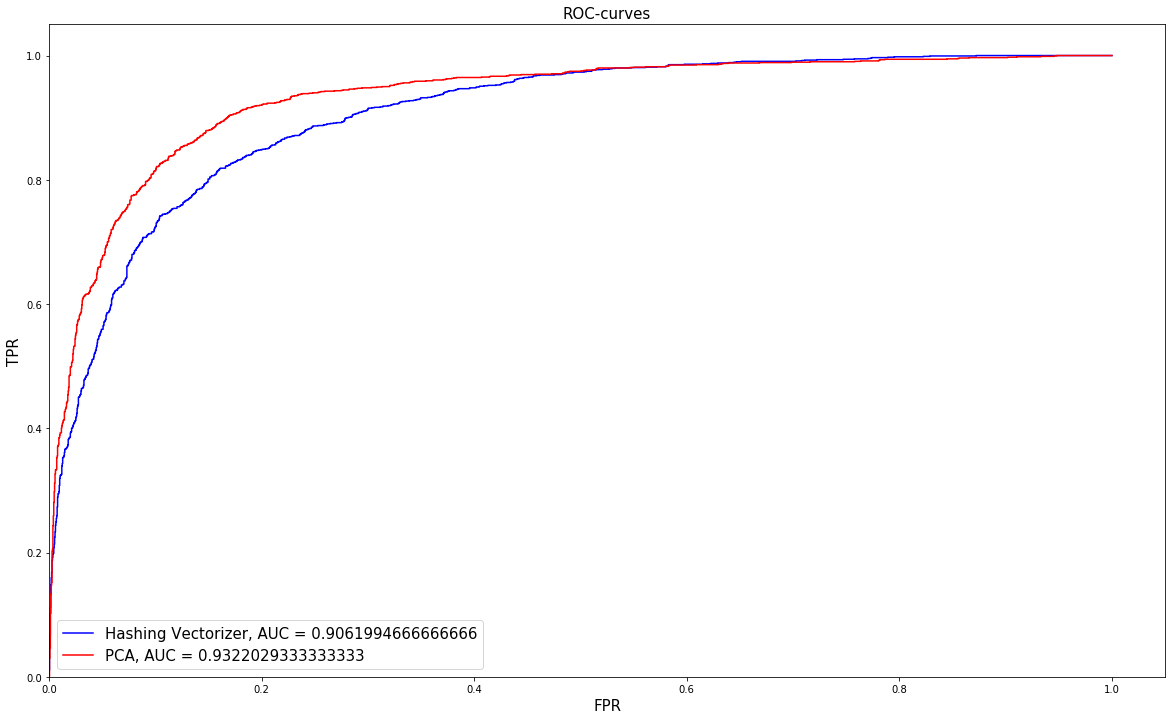

In [44]:
fpr, tpr, _ = roc_curve(y_test, y_prob_hash2000.T[1], pos_label=1)
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

plt.figure(figsize=(20, 12))
plt.step(fpr, tpr, label="Hashing Vectorizer, AUC = " + str(auc(fpr, tpr)), color='b')

plt.xlabel('FPR', fontsize=15)
plt.ylabel('TPR', fontsize=15)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.05])

fpr, tpr, _ = roc_curve(y_test, y_prob_pca.T[1], pos_label=1)
plt.step(fpr, tpr, label="PCA, AUC = " + str(auc(fpr, tpr)), color='r')
plt.title("ROC-curves", fontsize=15)
#plt.fill_between(fpr, tpr, alpha=0.2, color='r', **step_kwargs)

plt.legend(fontsize=15)

<font size=4, color=blue> Из графика и AUC видно, что PCA работает лучше.

Для первых трех компонент преобразования найдите топ-30 наиболее важных слов. Можете ли вы охарактеризовать как-то каждую из этих групп?

In [45]:
np.argsort(pca.components_[0])[len(pca.components_[0]) - 30:]

array([60037, 48716, 32161, 33722, 15261, 48100, 16222, 32465, 41834,
       30762, 20532, 55358, 36639,  9623, 23826,  9604, 60119, 33584,
       16341, 40751,  4577, 52787, 44716, 55679, 23424, 29899, 32222,
       20495, 36624,  7233])

In [46]:
print("First component:")
print(np.array(vectorizer.get_feature_names())[np.argsort(pca.components_[0])[len(pca.components_[0]) - 30:]])

First component:
['watch' 'seen' 'life' 'man' 'did' 'scene' 'does' 'little' 'plot' 'know'
 'films' 'think' 'movies' 'characters' 'great' 'character' 'way' 'make'
 'don' 'people' 'bad' 'story' 'really' 'time' 'good' 'just' 'like' 'film'
 'movie' 'br']


In [47]:
print("Second component:")
print(np.array(vectorizer.get_feature_names())[np.argsort(pca.components_[1])[len(pca.components_[1]) - 30:]])

Second component:
['chikatilo' 'sable' 'wwf' 'tag' 'cena' 'esther' 'bronte' 'kareena'
 'savalas' 'milo' 'dalton' 'starr' 'austin' 'undertaker' 'championship'
 'season' 'erika' 'sommer' 'chavez' 'episode' 'wrestlemania' 'ladder'
 'security' 'wwe' 'tucci' 'mall' 'capshaw' 'arquette' 'match' 'br']


In [48]:
print("Third component:")
print(np.array(vectorizer.get_feature_names())[np.argsort(pca.components_[2])[len(pca.components_[1]) - 30:]])

Third component:
['role' 'cast' 'screen' 'scene' 'doesn' 'american' 'new' 'woman' 'john'
 'way' 'cinema' 'performance' 'time' 'great' 'life' 'world' 'years'
 'characters' 'quite' 'best' 'horror' 'does' 'work' 'character' 'young'
 'director' 'story' 'man' 'films' 'film']


<font size=4, color=blue> Первая компонента выглядит как набор "общих" слов (story, plot, film) и основных маркеров, таких как good и bad. Вторая компонента в основном состоит из имен и фамилий известных режиссеров и актеров. Третью компоненту охарактеризовать уже сложнее: она состоит из "общих" слов (cinema, screen, role), некоторых ярких маркеров (best, great) и более "детализирующих" слов (horror, american).

### Какие еще могут быть способы обработки текстовых данных?

Как можно заметить, подход с мешком слов, в котором учитывается лишь факт вхождения слова в отзыв, весьма наивен, так как не позволяет учесть информацию в скольки отзывах встречалось данное слово (например, чтобы избавиться от очень редких слов). В этом случае может помочь [tf-idf кодирование](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).

Другой недостаток описанного в задании подхода заключается в использовании абсолютных частот слов. У некоторых слов они могут быть очень большими, в то же время у других — низкими. Чтобы "сгладить" разницу между ними, можно сделать логарифмирование, т.е. применить преобразование $x \to log(x + 1)$ (так как при bag-of-words кодировании могут встречаться 0).

Неплохое руководство можно найти в разделе [извлечения признаков](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction) из документации sklearn.


## Библиотека Vowpal Wabbit

Еще одним подходом для работы с текстовым данными является использование библиотеки [Vowpal Wabbit](https://github.com/JohnLangford/vowpal_wabbit/wiki).

VW представляет из себя хорошую реализация стохастического градиентного спуска для линейных моделей. К преимуществам и особенностям данной библиотеки можно отнести:
 - Считывание с диска происходит батчами, VW делает каждый следующий шаг градиентного спуска только по батчу, поэтому нет необходимости хранить всю выборку в памяти, из-за чего его удобно применять для больших выборок при ограниченных ресурсах.
 - Из коробки работают: нормализация признаков, взвешивание объектов, адаптивный градиентный шаг, матричные разложения, тематическое моделирование, активное обучение, обучение с подкреплением.
 - Реализация VW содержит различные методы оптимизации: сопряженные градиенты, квазиньютоновские методы (L-BFGS).
 - VW может быть запущен на кластере.

Перед началом работы с vw полезно будет ознакомиться с информацией по ссылкам:
 - [Ноутбук с семинара про VW (ближе к концу)](https://nbviewer.jupyter.org/urls/dl.dropbox.com/s/7szdykca8mzyngz/bow_vw.ipynb)
 - [Туториал по VW](https://github.com/JohnLangford/vowpal_wabbit/wiki/Tutorial)
 - [Описание формата входных данных](https://github.com/JohnLangford/vowpal_wabbit/wiki/Input-format)
 - [Описание параметров командной строки](https://github.com/JohnLangford/vowpal_wabbit/wiki/Command-line-arguments)

Приведите обучающую и тестовую выборки к формату пригодному для обучения модели с помощью vw: в качестве признаков используйте тексты отзывов как есть. Например:

In [105]:
X_train

array(['I really dislike both Shrek films. (Since their both \\PG\\" and have words in them I would never say myself, so I disliked them.)<br /><br />But when it comes to \\"Spirit: Stallion of the Cimarron,\\" which I just barely watched for the first time last month, I became a fan of animated films, other than Pixar. ***Spoilers ahead*** In \\"Spirit: Stallion of the Cimarron,\\" a horse foal is born and eventually becomes the leader of his heard. One night, he sees a strange light in the distance, and he sets off toward it. This action eventually leads to his capture, and several more things. Throughout the movie, we hear a narration. It\'s through the thoughts of Spirit, though the horses never talk. This is what makes the movie so goo. They (the movie makers) recored real horses to do the sounds the horses made; none of those sounds were made by humans.<br /><br />Spirit meets Rain, a beautiful mare, and Little Creek, a native-American, who owns Rain. Little Creek later frees Spi

**(2 балла) Задание 10.**

Обучите Vowpal Wabbit на полученной выборке. В качестве функции потерь (параметр [loss_function](https://github.com/JohnLangford/vowpal_wabbit/wiki/Loss-functions)) попробуйте использовать:
  - логистическую (logistic)
  - кусочно-линейную (hinge)

Постройте *Precision-Recall* и *ROC* кривые для каждой из получившихся моделей. Сравните время обучения и получившееся качество со временем обучения и качеством предыдущих моделей.

## Выводы

**(0.5 балла) Задание 11.**

В первой части лабораторной работы мы рассмотрели 2 способа подбора гиперпараметров и калибровки алгоритмов машинного обучения. Ответьте на следующие вопросы:

- В каких случаях случайный поиск гиперпараметра имеет преимущество, в сравнении с перебором по сетке? Приведите пример такого случая.
- Для какого типа задач машинного обучения имеет смысл использовать калибровку предсказаний? Приведите пример такой задачи.

Приведенные примеры не должны совпадать с упомянутыми ранее в работе.

<font size=4, color=blue> Случайный поиск гиперпараметра имеет смысл использовать, когда есть основания полагать, что резкий минимум ошибки достигается на очень маленьком диапазоне гиперпараметра, или когда требуется затратить не слишком много времени на поиск оптимального гиперпараметра, а при этом пространство перебора обещает быть достаточно большим. Например, при использовании случайного леса существует множество гиперпараметров, которые можно изменять: глубина деревьев, число деревьев, число признаков, характеристики листьев и т.д. Перебор по сетке может занять слишком много времени.
    
Калибровку предсказаний имеет смысл использовать, когда в оцениваемой ошибке фигурируют вероятности, а сама модель вероятности классов не выдает (или когда просто необходимо зачем-то знать предсказываемые вероятности). И снова в пример можно привести RandomForest, который не предсказывает вероятности классов.

**(0.5 балла) Задание 12.**

В второй части лабораторной работы мы рассмотрели несколько методов работы с текстовыми данными. Ответьте на следующие вопросы:

- Какие есть достоинства у рассмотренных методов представления текстовых данных? Поясните свой ответ для каждого рассмотренного метода.

<font size=4, color=blue> bag of words - простая схема построения, учитываются и редкие слова
    
сокращенный bag of words - меньше признаковое пространство, больше внимания к частым ярким словам-маркерам

pca - систематизация встречающихся слов, иногда "логичная" группировка, последовательная обработка логичных групп слов, существенно меньшее признаковое пространство при очень хорошем качестве

random forest и hashing - в разы меньше признаков почти без потери качества, ускорение работы crossval

random forest - отбор "логичных" важных слов

- Каким общим недостатком обладают данные методы?

<font size=4, color=blue> Все эти методы оперируют количественными показателями, почти или совсем не учитывают взаимосвязь слов и не работают с целыми языковыми конструкциями (словосочестаниями, предложениями). Работают как "машины", а не как устроен реальный человеческий язык (метафоры, шутки, интонации, устойчивые выражения).

- Какие модели машинного обучения больше подходят для работы с текстовыми данными на практике и почему? В чём их преимущество перед другими алгоритмами?